# Webkamera képet megjelenítő és feldolgozó python szkript

Az alábbi kódrészlet egy weblapon nyilvánosan elérhető, állandó irányban rögzített webkamera által mutatott tájképet egy időpillanatban http kéréssel letölti, és a megkapott kép átlagos fényerősségét figyelembe véve pedig megbecsüli, hogy nappal vagy éjszaka van :) .

Az eredeti elképzelésem szerint a webkamera élő videó-streamjéből mentettem volna le egy-egy képkockát, de mivel ez nem volt mindig elérhető, ezért maradtam a kb. fél percenként frissülő http-n keresztül elérhető kamera kép letöltésénél.

## Vizsgált tájkép

Budapesten a "Művészetek Palotája" épület tetején kb. észak-kelet irányba fordítva, az [idokep.hu](https://www.idokep.hu/) weboldalon elérhetővé téve:

https://www.idokep.hu/webkamera/mupa

Itt a kamera képe kb.15-20 másodpercenként frissül. A városi környezetet olyan távolságból mutatja, hogy a rajta szereplő mozgásokból származó fényintenzitás ingadozások elhanyagolhatóak az időjárás változás és napszak változásból adódó fényintenzitás változásokhoz képest. Kizárólag az éjszaka során fordul elő, hogy a környező épületek kivilágításának változása észrevehető a detektált fényintenzitásban. A tájolásának köszönhetően a 24 órás időszak nagy részen nem látszódik a nap, emiatt a kamerakép látszólagos fényintenzitása nappal sem ingadozik túlzottan.


## Szükséges python csomagok

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import requests
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

## Vizsgált adatok

Ahhoz, hogy csupán a fényerő alapján el lehessen dönteni egy fix irányban rögzített kamera képéről, hogy nappal vagy éjszaka van rajta, szükséges hogy meghatározzuk a kép jellemző fényerejét nappal, éjszaka és a kettő közötti átmenetek során is.

Ehhez 24 órán keresztül 5 percenként lementettem egy-egy darab jpeg formátumú képet és megvizsgáltam az átlagos fényintenzitást a színes képet jellemző RGB (vörös-zöld-kék) csatornákon külön-külön, valamint a szürkeárnyalatossá konvertálás után a szürkeárnyalatos képen is.

A képek letöltését egy webböngésző "nevében" az alábbi fügvénnyel végeztem a `timeloop` python csomag által automatizálva. A letöltések idejeit a fájlnevekben mentettem el. 


In [2]:
def download_and_save_image(image_url, filename) :
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:78.0) Gecko/20100101 Firefox/78.0"}
    try :
        response = requests.get(image_url, headers=headers)
        
        time_string = datetime.now().strftime("_%Y%m%d_%H%M%S")
        filename +=  time_string + ".jpg"
        
        output_file = open(filename, "wb")
        output_file.write(response.content)
        output_file.close()
        
        print("sikeres letoltes:", filename)
    
    except Exception as e :
        print(e)



## Néhány jellemző kép



#### Nappal

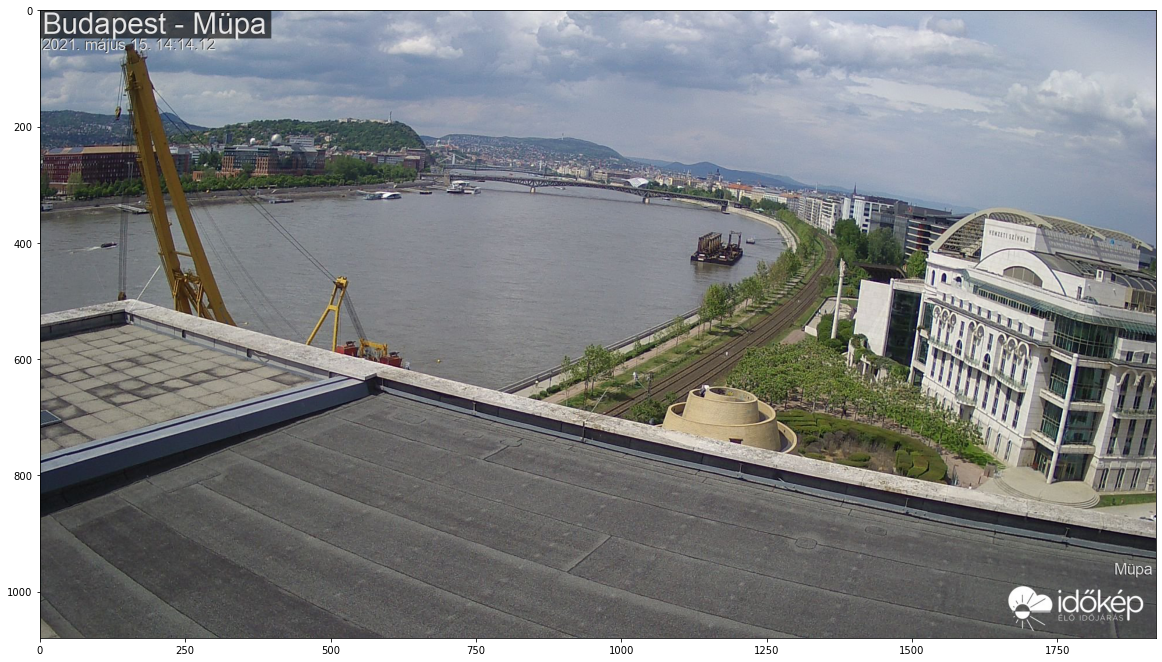

In [3]:
image_daytime = cv2.imread("./mupa_20210515_141424.jpg")

rgb_image = cv2.cvtColor(image_daytime, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
_ = plt.imshow(rgb_image)


#### Naplemente

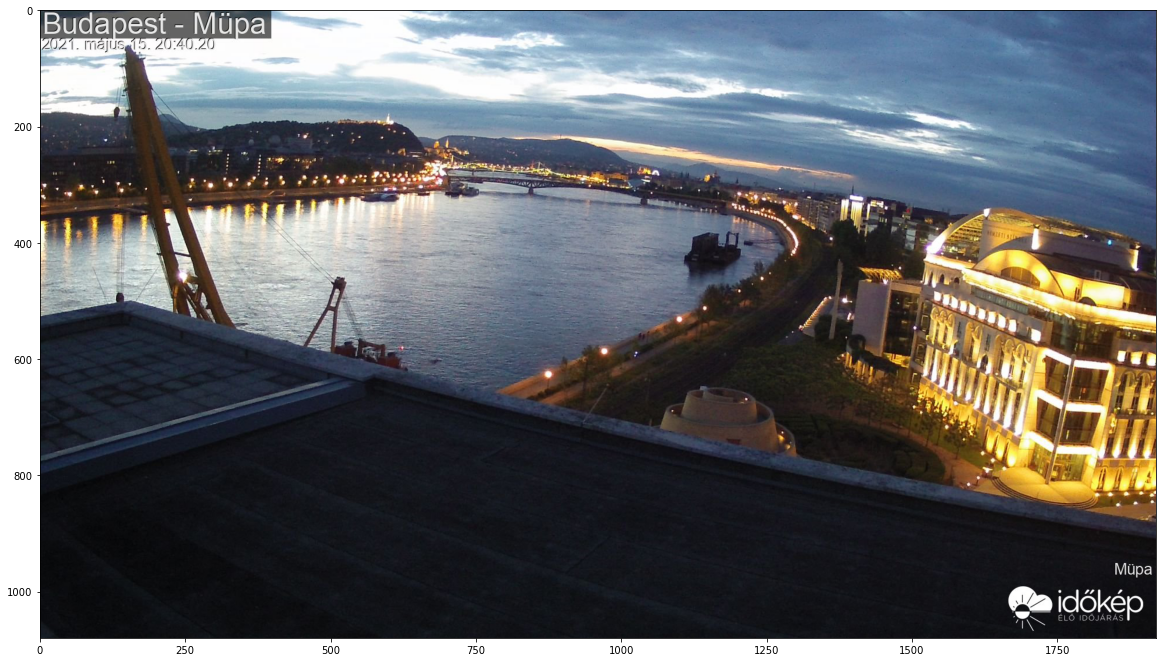

In [4]:
image_sunset = cv2.imread("./mupa_20210515_204034.jpg")

rgb_image = cv2.cvtColor(image_sunset, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
_ = plt.imshow(rgb_image)

#### Éjszaka

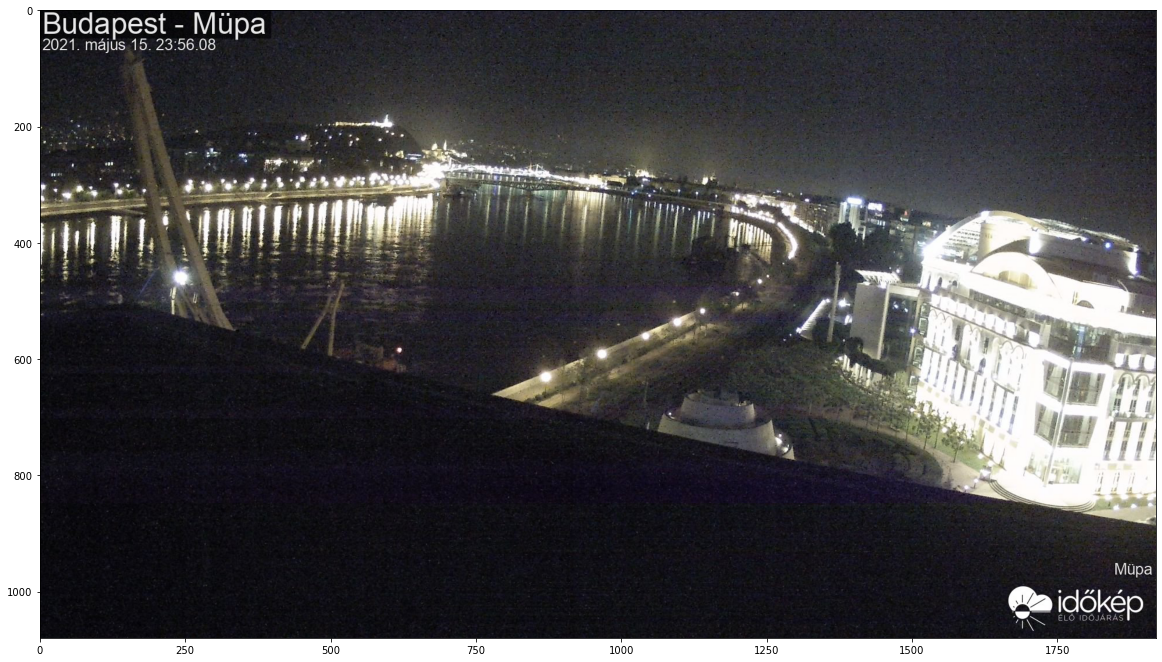

In [5]:
image_night = cv2.imread("./mupa_20210515_235613.jpg")

rgb_image = cv2.cvtColor(image_night, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
_ = plt.imshow(rgb_image)


#### Napkelte

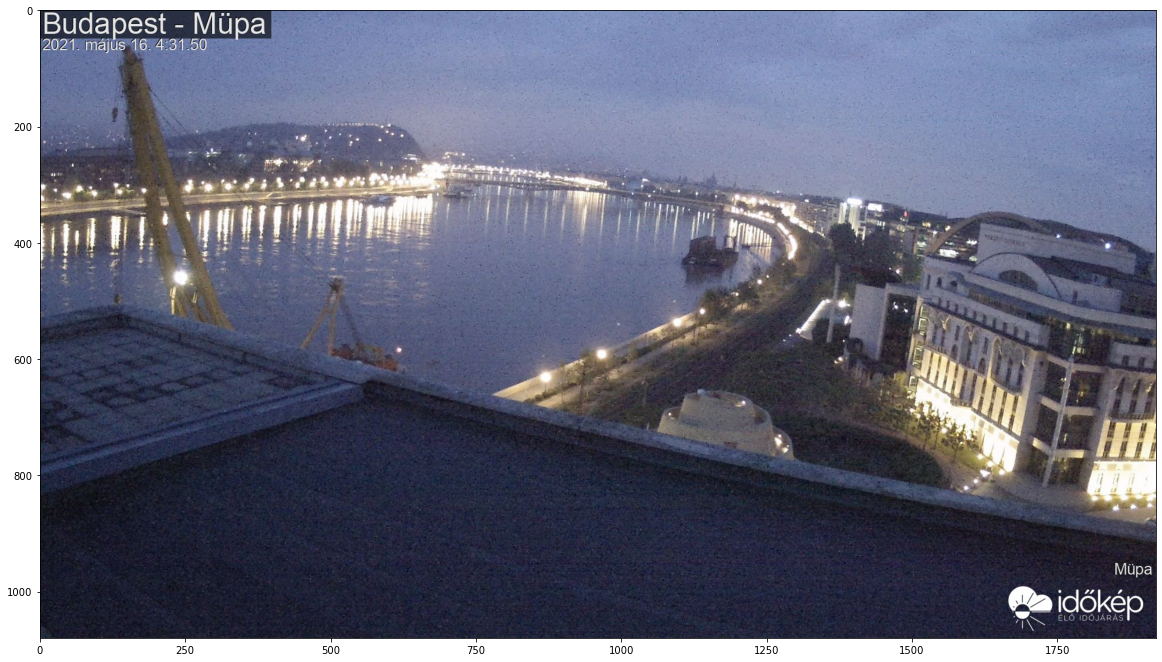

In [6]:
image_sunrise = cv2.imread("./mupa_20210516_043204.jpg")

rgb_image = cv2.cvtColor(image_sunrise, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
_ = plt.imshow(rgb_image)

## A képek átlagos fényintenzitásának meghatározása R, G, B csatornákon valamint szürkeárnyalatos skálán

2021 május 15. 11:59 és 2021 május 16. 12:03 időpontok között a közel 24 órás időszak alatt egyenletes időközönként összesen 289 darab képet töltöttem le. A nappalra és éjszakára jellemző fényintenzitásokat a kép pixeleinek RGB csatornáinak intenzitásainak átlagolásával határoztam meg. Ezt kiegészítettem még a szürkeárnyalatosra (grayscale) konvertált kép átlagos fényintenzitásának vizsgálatával. A 8 bites RGB kódolás miatt minden csatorna esetén 0 a minimum és 255 a maximális lehetséges fényintenzitás értéke.

Az elmentett képek beolvasását és a fényintenzitásuk meghatározását OpenCV könyvtár segítségével az alábbi függvénnyel végeztem el.

In [7]:

def process_image_file(file_path) :

    image = cv2.imread(file_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # cv2 -> BGR
    blue = np.average(image[:, :, 0])
    green = np.average(image[:, :, 1])
    red = np.average(image[:, :, 2])
    
    gray = np.average(grayscale_image[: ,:])
    
    return (red, green, blue, gray)


#### 24 órás időintervallumban letöltött képek átlagos fényességének meghatározása R, G, B csatornákon

Az összes képre elvégezve az átlagolást az eredményt egy pandas dataframbe valamint ezt exportálva egy CSV fájlba mentettem el.


In [8]:
def create_dataframe() :
    
    image_directory = "./images/mupa/"
    
    date_time_list = []
    average_RGB_Gray = []
    
    for filename in os.listdir(image_directory) :
        path = image_directory + filename
        
        date_time_parts = filename.split("_")
        date = date_time_parts[1]
        time = date_time_parts[2].split(".")[0]
        
        date_time_list.append(date + "_" + time)
        average_RGB_Gray.append(process_image_file(path))
        #print(path)
    
    date_times = pd.Series(date_time_list)
    date_time_series = pd.to_datetime(date_times, format="%Y%m%d_%H%M%S")    
    rgbg_dataframe = pd.DataFrame(average_RGB_Gray, columns=["red", "green", "blue", "gray"])    
    allday_brightness = pd.concat([pd.DataFrame(date_time_series, columns=["time"]), rgbg_dataframe], axis=1)
    
    return allday_brightness
    

In [9]:
# allday_brightness = create_dataframe()
# allday_brightness.to_csv("allday_brightness.csv")

# A több mint 100Mb-nyi képet nem töltöttem fel, ezért csak az elkészített CSV fájlt olvasom vissza a továbbiakban.

A hosszabb idejű adatfeldolgozás helyett a továbbiakban mindig az elmentett CSV fájlból beolvasott dataframe -et használom.

In [10]:
allday_brightness = pd.read_csv("allday_brightness.csv", index_col=0)

In [11]:
allday_brightness

time         red       green        blue        gray
0    2021-05-15 11:59:04  116.952296  116.881029  114.463065  116.612141
1    2021-05-15 12:04:04  113.720381  115.594394  117.685462  115.263532
2    2021-05-15 12:09:05  117.324078  118.823742  118.725582  118.355114
3    2021-05-15 12:14:06  120.389866  122.104608  124.975720  121.916096
4    2021-05-15 12:19:06  121.355446  123.524062  126.022001  123.157476
..                   ...         ...         ...         ...         ...
284  2021-05-16 11:43:27  112.162925  112.257150  110.568625  112.022816
285  2021-05-16 11:48:28  111.862444  112.426706  110.735953  112.060363
286  2021-05-16 11:53:29  117.831494  118.551558  117.384603  118.202073
287  2021-05-16 11:58:30  120.743627  121.326720  121.116123  121.128325
288  2021-05-16 12:03:31  122.702533  123.590129  123.194360  123.281183

[289 rows x 5 columns]

In [12]:
allday_brightness.describe()

red       green        blue        gray
count  289.000000  289.000000  289.000000  289.000000
mean    97.944013   98.195781   98.677934   98.167267
std     28.350597   29.100485   27.257558   28.646801
min     46.757638   45.893852   49.869538   46.592888
25%     63.658486   62.507557   64.849063   63.169369
50%    114.423408  115.450063  113.919584  114.884930
75%    120.292426  120.973310  120.108982  120.736222
max    127.158886  127.604971  126.735070  127.313779

Látható, hogy a nappali maximum intenzitások 125 és 130 között, az éjszakai minimum intenzitások pedig 45 és 50 között vannak.


A kapott eredmények az idő függvényében az alábbi grafikonon figyelhetőek meg a déltől délig tartó 24 órás időszakban.

A naplemente valamivel este 20:00 óra után volt, a napfelkelte pedig hajnali 5:00 óra körül.

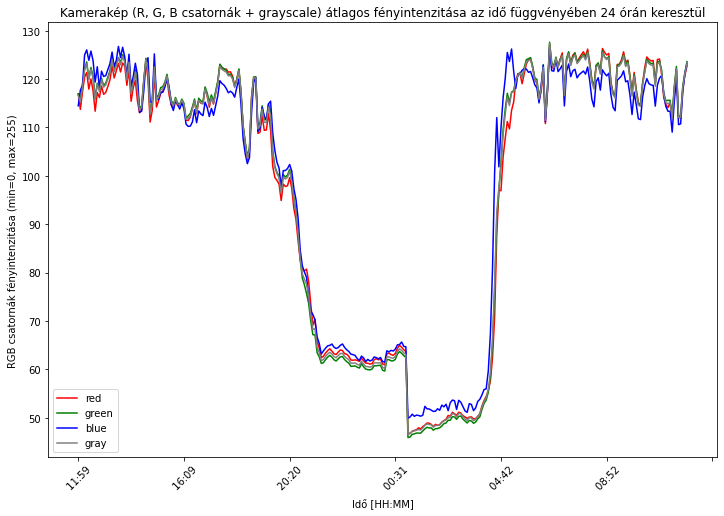

In [13]:
ax = allday_brightness.plot(
    x="time",
    y=["red", "green", "blue", "gray"],
    color=["red", "green", "blue", "gray"],
    figsize=(12.0, 8.0),
    title="Kamerakép (R, G, B csatornák + grayscale) átlagos fényintenzitása az idő függvényében 24 órán keresztül",
    xlabel="Idő [HH:MM]",
    ylabel="RGB csatornák fényintenzitása (min=0, max=255)",
    rot=90
)
xtick_label_texts = [ label.get_text()[10:-3] for label in ax.get_xticklabels()]
_ = ax.set_xticklabels(xtick_label_texts, rotation=45)


Látható, hogy a 3 színcsatorna intenzitása és a szürkeárnyalatos intenzitás is (ami természetesen az RGB komponensek lineáris kombinációja) szinte teljesen együtt mozog a 24 órás időtartam alatt.

Ezért a nappali és éjszakai fényintenzitás jellemzésére kizárólag a szürkeárnyalatos intenzitást választottam ki, az erre vonatkozó grafikon látható lejjebb.

In [14]:
ax = allday_brightness.plot(
    x="time",
    y=["gray"],
    color=["black"],
    figsize=(12.0, 8.0),
    title="Kamerakép átlagos grayscale fényintenzitása az idő függvényében 24 órán keresztül",
    xlabel="Idő [HH:MM]",
    ylabel="Relatív fényintenzitás (min=0.0, max=1.0)",
    rot=90
)
xtick_label_texts = [ label.get_text()[10:-3] for label in ax.get_xticklabels()]
_ = ax.set_xticklabels(xtick_label_texts, rotation=45)


Éjszaka 1:00 óra körül figyelhető meg, ahogyan a szomszédos épület (Nemzeti Színház) kivilágítását lekapcsolják, ezt figyelembe véve, a grafikont kiértékelve a teljes (0, 255) fényintenzitás intervallumra vonatkozóan a nappali fényintenzitás alsó határát a 100-as értéknél, az éjszakai fényintenzitás felső határát pedig a 70-es értéknél húztam meg. A két érték között pedig napfelkelte vagy naplemente van.

## A kiértékelő szkript

A fenti (100 és 70) értékeket használva hoztam létre az alábbi napszakot megbecslő függvényt.

In [15]:
def night_or_daytime(bgr_image) :
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_value = np.average(grayscale_image[: ,:])
    brightness = gray_value
    
    decision = None
    daytime_limit = 100.0
    night_limit = 70.0
    
    if brightness > daytime_limit :
        decision = "NAPPAL"
    elif brightness > daytime_limit :
        decision = "ALKONYAT VAGY PIRKADAT"
    else:
        decision = "ÉJSZAKA"
    
    return decision


Ezzel a kiértékelő függvénnyel megbecsülhetjük az aktuálisan letöltött kameraképen látható napszakot, amely szerint a modell szerint lehet:

- nappal
- alkonyat vagy pirkadat
- éjszaka


Az alább képletöltő és kiértékelő szkriptet tetszőleges időpontban futtatva, a képről megbecsülhető, hogy nappal vagy éjszaka vagy átmeneti időszak van rajta. Ez jelenleg a kép fölé kerül kiírásra.

Az alábbi letöltött képet kiértékelve megállípítható, hogy a képen NAPPAL van.


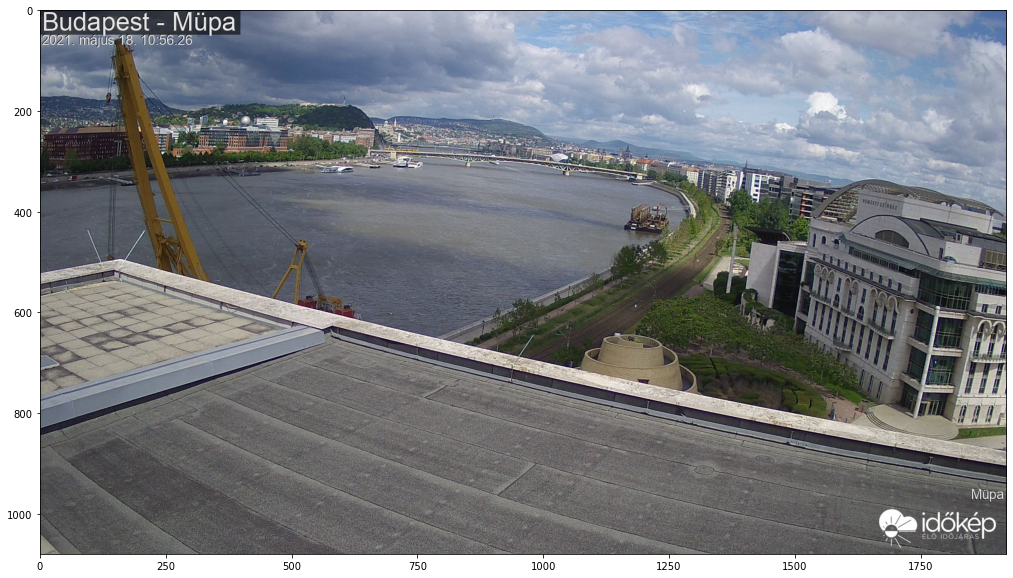

In [16]:
def download_image(image_url) :
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:78.0) Gecko/20100101 Firefox/78.0"}
    image = None
    try :
        response = requests.get(image_url, headers=headers)
        image_bytes = response.content
        image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), 1)
    
    except Exception as e :
        print(e)
    return image
 

image_url = "https://cam.idokep.hu/mupa/orig.jpg"
image = download_image(image_url)

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,10))
_ = plt.imshow(rgb_image)

    
answer = night_or_daytime(image)
answer

print("Az alábbi letöltött képet kiértékelve megállípítható, hogy a képen " + answer + " van.")

